
**Install requirements**

In [ ]:
!pip3 install torch torchvision torchaudio

In [ ]:
!pip3 install 'tqdm'

##### **Import libraries**

In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

##### **Define Data Preprocessing**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

This Python code is defining transformations for image data during the training and evaluation phases of a machine learning model. These transformations are often necessary to prepare the data for input into a model. 

The transformations are defined using the `transforms.Compose` function from the `torchvision` library, which allows multiple transformations to be chained together.

In the training phase, the following transformations are applied:

1. `transforms.Resize(256)`: This resizes the shortest side of the input PIL image to 256 while maintaining the aspect ratio.

2. `transforms.CenterCrop(224)`: This crops a central square patch of the image of size 224x224. 

3. `transforms.ToTensor()`: This converts the PIL Image, which is in the range [0, 255], to a PyTorch Tensor in the range [0, 1].

4. `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`: This normalizes the tensor image with mean and standard deviation. The first tuple (0.5, 0.5, 0.5) is the mean for each channel of the image and the second tuple is the standard deviation for each channel. The normalization helps in faster and more stable training of neural networks.

The same transformations are applied in the evaluation phase as well. 

##### **Prepare Dataset**

In [ ]:
from torchvision.datasets import VisionDataset

from PIL import Image

import os
import os.path
import sys


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")


class Caltech(VisionDataset):
    def __init__(self, root, split="train", transform=None, target_transform=None):
        super(Caltech, self).__init__(
            root, transform=transform, target_transform=target_transform
        )

        self.split = split  # This defines the split you are going to use

        """
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indexes to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class)
        """

        def make_indexed_classes(root):
            classes = [
                d.name for d in os.scandir(root) if d.name != "BACKGROUND_Google"
            ]
            classes.sort()
            class_to_idx = {classes[i]: i for i in range(len(classes))}
            return classes, class_to_idx

        # open split file
        def make_dataset(root, split):
            # folder structure:
            # Caltech101/
            #     101_ObjectCategories/
            #         accordion/
            #             image_0001.jpg
            #
            #     train.txt -> lines with structure: classname/image_xxxx.jpg
            #     test.txt  -> lines with structure: classname/image_xxxx.jpg

            with open(os.path.join("Caltech101", split + ".txt"), "r") as f:
                lines = f.readlines()
                lines = [
                    line.strip()
                    for line in lines
                    if line.split("/")[0] != "BACKGROUND_Google"
                ]

            dataset = [
                (line.split("/")[0], line.split("/")[1])
                for line in lines
            ]

            return dataset

        self.classes, self.indexed_classes = make_indexed_classes(
            root
        )  # [classname, classname, ...], {classname:classindex, ...}
        self.dataset = make_dataset(root, split)  # [(classindex,imagename),...]

    def __getitem__(self, index):
        """
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """

        # image, label = ... # Provide a way to access image and label via index
        # Image should be a PIL Image
        # label can be int

        label, image_name = self.dataset[index]

        image_path = os.path.join(self.root, label, image_name)

        image = pil_loader(image_path)

        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)

        return image, self.indexed_classes[label]

    def __len__(self):
        """
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        """
        length = len(self.dataset)
        return length


This Python code defines a custom dataset class named `Caltech` that inherits from the `VisionDataset` class provided by the `torchvision` library. This class is designed to handle image data from the Caltech dataset.

The `pil_loader` function is a helper function that opens an image file, converts it to RGB, and returns it as a PIL Image object.

The `Caltech` class has an `__init__` method that initializes the class. It takes several parameters including `root`, `split`, `transform`, and `target_transform`. 
- `root` parameter is the path to the dataset
- `split` defines the dataset split to use (either 'train' or 'test')
- `transform` and `target_transform` are optional callable objects that apply transformations to the images and labels

The `__getitem__` method is a special method that allows the `Caltech` objects to be indexed so that they can be accessed like lists (e.g., `dataset[i]`). It takes an index and returns the corresponding image-label pair. The image is a PIL Image object and the label is an integer. If a transform was passed to the `__init__` method, it is applied to the image before it is returned.

The `__len__` method is another special method that returns the number of items in the dataset. This is used by PyTorch's DataLoader among other things to manage the data loading process.


In [ ]:
from sklearn.model_selection import train_test_split

# Clone github repository with data
import pathlib
# print(pathlib.Path().resolve())
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

# train_indexes = [] # split the indices for your train split
# val_indexes = []# split the indices for your val split

all_indexes=range(len(train_dataset))
train_indexes,val_indexes = train_test_split(all_indexes,test_size=0.25,random_state=42)


# new datatset with only images from the indexes
train_dataset = Subset(train_dataset, train_indexes)
val_dataset = Subset(train_dataset, val_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

##### **Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Creating DataLoader objects for training, validation, and testing datasets. DataLoader is a utility class in PyTorch that helps manage the loading and batching of data.

Breakdown of the parameters used:

1. `train_dataset`, `val_dataset`, `test_dataset`: These are the dataset objects that you want to load. They should be instances of a class that implements the PyTorch Dataset interface.

2. `batch_size=BATCH_SIZE`: This specifies the number of samples per batch. Batching is a common technique used to train models more efficiently.

3. `shuffle=True` for `train_dataloader`: This indicates whether the data should be shuffled at every epoch. Shuffling is often used during training to ensure that the model doesn't learn anything from the order of the samples. For validation and test datasets, shuffling is usually not necessary.

4. `num_workers=4`: This specifies the number of subprocesses to use for data loading. The more workers, the faster your data can be loaded into memory, up to the limit of your system's capabilities. More workers also mean more memory usage.

5. `drop_last=True` for `train_dataloader`: This is an optional argument that specifies whether the last incomplete batch should be dropped if the dataset size is not divisible by the batch size. This is typically set to `True` for training data but not for validation or testing data.



##### **Prepare Network**

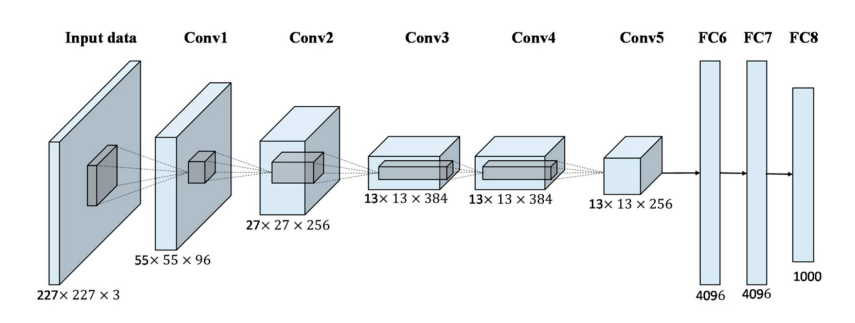

In [ ]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

AlexNet was originally designed for the ImageNet competition, which has 1000 classes, but in this case, the model is being adapted for the Caltech-101 dataset, which has 101 classes.

Breakdown of the code: `net.classifier[6] = nn.Linear(4096, NUM_CLASSES)`: 

AlexNet is composed of a features section (convolutional layers) and a classifier section (fully connected layers). 

The classifier section is a sequential container of modules, and the 6th module in the classifier section is the final fully connected layer. 

This line replaces the final fully connected layer with a new one. The new layer has 4096 inputs (to match the output of the previous layer in AlexNet) and `NUM_CLASSES` outputs.


##### **Prepare Training**

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;)
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print(len(train_dataloader))

Part of a machine learning pipeline using the PyTorch library. It's setting up the loss function, optimizer, and learning rate scheduler for training a neural network model.

Breakdown of the code:

1. `criterion = nn.CrossEntropyLoss()`: This line defines the loss function to be used during training. Cross entropy loss is commonly used for classification tasks.

2. `parameters_to_optimize = net.parameters()`: This line specifies which parameters of the model should be updated during training. In this case, all parameters of the model are being optimized.

3. `optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)`: This line defines the optimizer to be used during training. The optimizer is responsible for updating the model's parameters based on the gradients computed during backpropagation. Here, Stochastic Gradient Descent (SGD) is used with momentum and weight decay.

4. `scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)`: This line defines a learning rate scheduler, which adjusts the learning rate during training. In this case, a step learning rate scheduler is used, which multiplies the learning rate by a factor of `gamma` every `STEP_SIZE` epochs. This is a common technique for gradually lowering the learning rate.

5. `print(len(train_dataloader))`: This line prints the number of batches in the training data loader. This could be useful for understanding how many iterations of training will occur in each epoch.


##### **Train**

In [ ]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:

    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Step the scheduler
  scheduler.step()

Training loop for the model. 

Breakdown of the code:

1. `net = net.to(DEVICE)`: This line moves the model to the specified device. If `DEVICE` is set to 'cuda', this will move the model to the GPU.

2. `cudnn.benchmark`: This line is meant to optimize the runtime by using the cuDNN auto-tuner to find the best algorithm for the hardware. 

3. The **outer loop** `for epoch in range(NUM_EPOCHS):` iterates over the epochs. An epoch is one complete pass through the entire training dataset.

    - `print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))`: This line prints the current epoch number, total number of epochs, and current learning rate.

    - The **inner loop** `for images, labels in train_dataloader:` iterates over the batches of data in the training dataset.

        * `images = images.to(DEVICE)` and `labels = labels.to(DEVICE)`: These lines move the images and labels to the specified device.

        * `net.train()`: This line sets the model to training mode. This is necessary because some layers, like dropout and batch normalization, behave differently during training and evaluation.

        * `optimizer.zero_grad()`: This line sets the gradients of all the model parameters to zero. PyTorch accumulates gradients, so they need to be manually zeroed before each new backward pass.

        * `outputs = net(images)`: This line performs the forward pass, passing the images through the model to get the outputs.

        * `loss = criterion(outputs, labels)`: This line computes the loss by comparing the model's outputs to the ground truth labels.

        * The `if` statement logs the loss every `LOG_FREQUENCY` steps.

        * `loss.backward()`: This line performs the backward pass, computing the gradients of the loss with respect to the model parameters.

        * `optimizer.step()`: This line updates the model parameters based on the gradients.

    - `scheduler.step()`: This line is called after each epoch and updates the learning rate according to the learning rate scheduler.



##### **Validation**

In [ ]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

##### **Test**

In [ ]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))